# Quantization and support points

See the [multivariate methods document](https://github.com/kshedden/case_studies/blob/main/methods/multivariate.md) for an overview of quantization.
The "support points" method used in this notebook was originally proposed in this paper: https://arxiv.org/pdf/1609.01811.pdf.  You don't need to review this paper, as sufficient background is provided in this notebook, in the multivariate methods document, and in the lectures. 

In [1]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.nonparametric.smoothers_lowess import lowess
from read import *

Subsample the profiles for speed.

In [2]:
m = 20000
n = temp.shape[1]
ii = np.random.choice(n, m, replace=False)
temp = temp[:, ii]
psal = psal[:, ii]
lat = lat[ii]
lon = lon[ii]
day = day[ii]

The function below randomly subsamples columns of X, by default taking 2000 columns.

In [3]:
def dsamp(X, cmax=2000):
    """
    Subsample the columns of X so that there are more than 'cmax' columns.
    """
    if X.shape[1] > cmax:
        ii = np.random.choice(X.shape[1], cmax, replace=False)
        X = X[:, ii]
    return X

The function below calculates the average pairwise distance between a column of X and a column of Y.  This is an important component of the energy distance.

In [4]:
def ediff(X, Y):
    """
    Calculate the average L2 distance between a column of X and a column of Y.
    """
    if X.shape[1] > Y.shape[1]:
        X, Y = Y, X
    d = 0.0
    for j in range(X.shape[1]):
        u = Y - X[:, j][:, None]
        d += np.sqrt((u**2).sum(0)).sum()
    d /= (X.shape[1] * Y.shape[1])
    return d

It will be helpful to know the "diameters" of the temperature and salinity profile sets, which can be calculated as below.

In [5]:
temp1 = dsamp(temp)
ediff(temp1, temp1)

40.52121963455586

In [6]:
psal1 = dsamp(psal)
ediff(psal1, psal1)

4.939520425312684

The function below estimates the energy distance between the distributions of the columns of X and Y.

In [7]:
def energy_distance(X, Y):
    """
    Estimate the energy distance between P(X) and P(Y).
    """
    X = dsamp(X)
    Y = dsamp(Y)
    return 2*ediff(X, Y) - ediff(X, X) - ediff(Y, Y)

The function below is a utility function, used in the majorization/maximization (MM) algorithm for constructing support points.

In [8]:
# Equation 22 in Mak et al.
def update_support(X, Y):
    N, p = Y.shape
    n, _ = X.shape
    XX = np.zeros((n, p))

    for i in range(n):
        Dx = X[i, :] - X
        DxN = np.linalg.norm(Dx, axis=1)
        DxN[i] = np.inf
        Dy = X[i, :] - Y
        DyN = np.linalg.norm(Dy, axis=1)
        q = (1/DyN).sum()
        XX[i, :] = np.dot(1/DxN, Dx) * (N / n)
        XX[i, :] += np.dot(1/DyN, Y)
        XX[i, :] /= q

    return XX

The function below uses the MM algorithm to construct N support points representing the distribution of the columns of Y.

In [9]:
def support(Y, N, maxiter=1000):
    """
    Calculate N support points for the data in Y.  The points are stored in the rows of Y.
    """
    n, p = Y.shape
    X = np.random.normal(size=(N, p))

    for i in range(maxiter):
        X1 = update_support(X, Y)
        ee = np.linalg.norm(X1 - X)
        X = X1
        if ee < 1e-8:
            break

    return X

The support point algorithm is somewhat slow, so we limit the number of iterations.

In [10]:
support_iter = 100

In [11]:
def plot_support_map(ii, title):
    plt.clf()
    plt.figure(figsize=(8, 7.25))
    ax = plt.axes([0.05, 0.05, 0.84, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([115, 290, -70, 60])

    for j in range(ii.max() + 1):
        jj = np.flatnonzero(ii == j)
        plt.scatter(lon[jj], lat[jj], s=8, label=str(1+j), transform=ccrs.Geodetic(), rasterized=True)

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)

    plt.title(title)
    plt.show()

Find the position of the closest support point in the rows of S to the vectors in the rows of X:

In [12]:
def support_neighbor(X, S):
    ii = np.zeros(X.shape[1]).astype(int)
    for i in range(X.shape[1]):
        d = ((X[:, i] - S)**2).sum(1)
        ii[i] = np.argmin(d)
    return ii

Plot support points for temperature and salinity separately.

npt= 1


<Figure size 640x480 with 0 Axes>

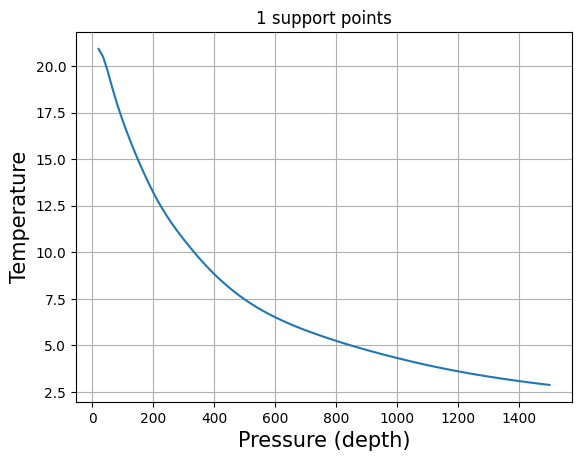

npt= 5


<Figure size 640x480 with 0 Axes>

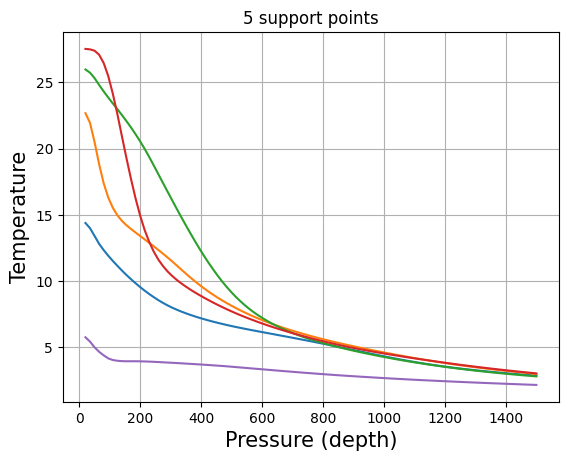

npt= 10


<Figure size 640x480 with 0 Axes>

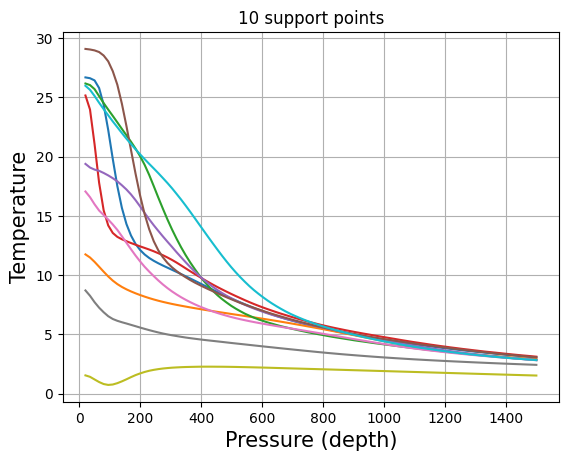

npt= 1


<Figure size 640x480 with 0 Axes>

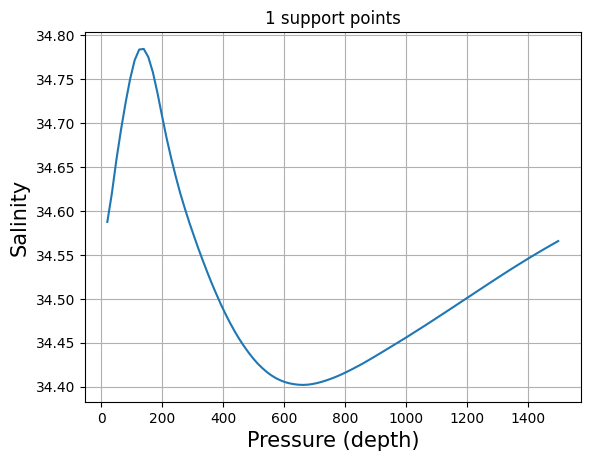

npt= 5


<Figure size 640x480 with 0 Axes>

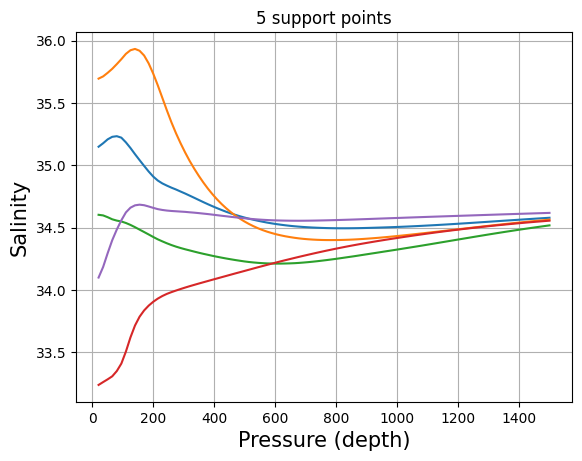

npt= 10


<Figure size 640x480 with 0 Axes>

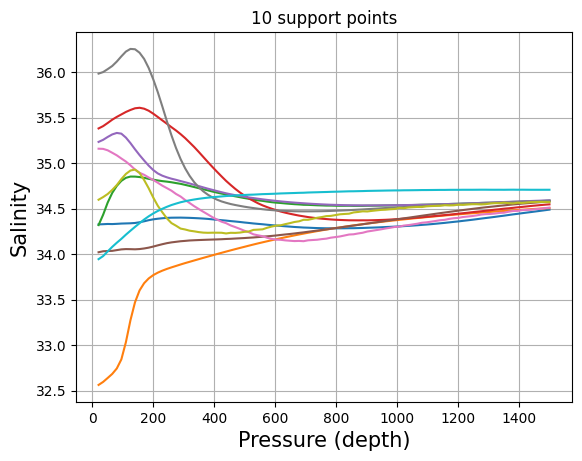

In [13]:
spt = {} # Save the support points for use later

for (j,x) in enumerate([temp, psal]):
    spt[j] = {}
    
    # Make plots with different numbers of support points.
    for npt in [1, 5, 10]:
        print("npt=", npt)
        X = support(x.T, npt, maxiter=support_iter)
        spt[j][npt] = X
        plt.clf()
        plt.figure(figsize=(6.4,4.8))
        plt.grid(True)
        plt.title("%d support points" % npt)
        for i in range(npt):
            plt.plot(pressure, X[i, :], "-")
        plt.xlabel("Pressure (depth)", size=15)
        plt.ylabel(["Temperature", "Salinity"][j], size=15)
        plt.show()

Plot support points for the combined temperature and salinity trajectories.  Normalize the ranges of temperature and salinity so that the support points are more equally determined by the two measures.

npt= 3


<Figure size 640x480 with 0 Axes>

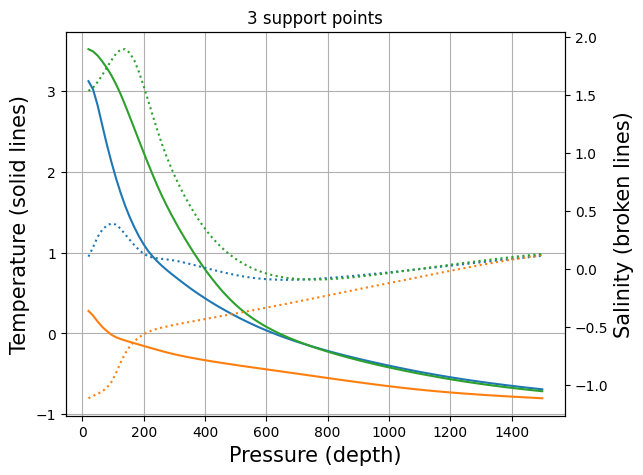

npt= 5


<Figure size 640x480 with 0 Axes>

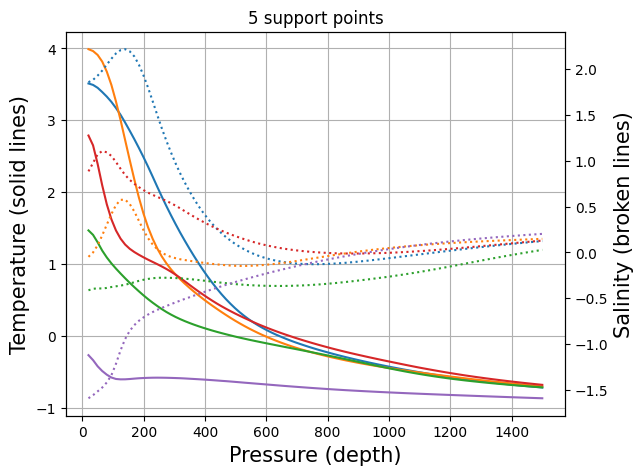

npt= 10


<Figure size 640x480 with 0 Axes>

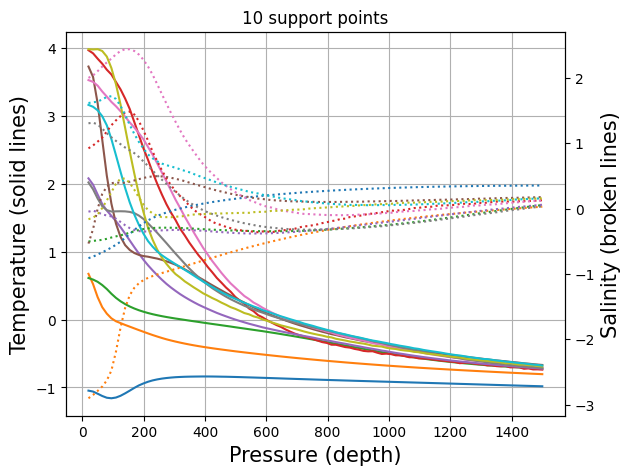

In [16]:
cm = matplotlib.colormaps["tab10"]
tempz = (temp - temp.mean()) / temp.std()
psalz = (psal - psal.mean()) / psal.std()
pt = np.vstack([tempz, psalz])
for npt in 3,5,10:
    print("npt=", npt)
    X = support(pt.T, npt, maxiter=support_iter)
    plt.clf()
    plt.figure(figsize=(6.4,4.8))
    plt.axes([0.1, 0.1, 0.78, 0.8])
    plt.grid(True)
    plt.title("%d support points" % npt)
    ax1 = plt.gca()
    for i in range(npt):
        ax1.plot(pressure, X[i, 0:100], "-", color=cm(i/10))
    ax1.set_ylabel("Temperature (solid lines)", size=15)
    ax2 = ax1.twinx()
    for i in range(npt):
        ax2.plot(pressure, X[i, 100:200], ":", color=cm(i/10))
    ax2.set_ylabel("Salinity (broken lines)", size=15)
    ax1.set_xlabel("Pressure (depth)", size=15)
    plt.show()

Make maps showing the distribution of points falling closest to each support point.

<Figure size 640x480 with 0 Axes>

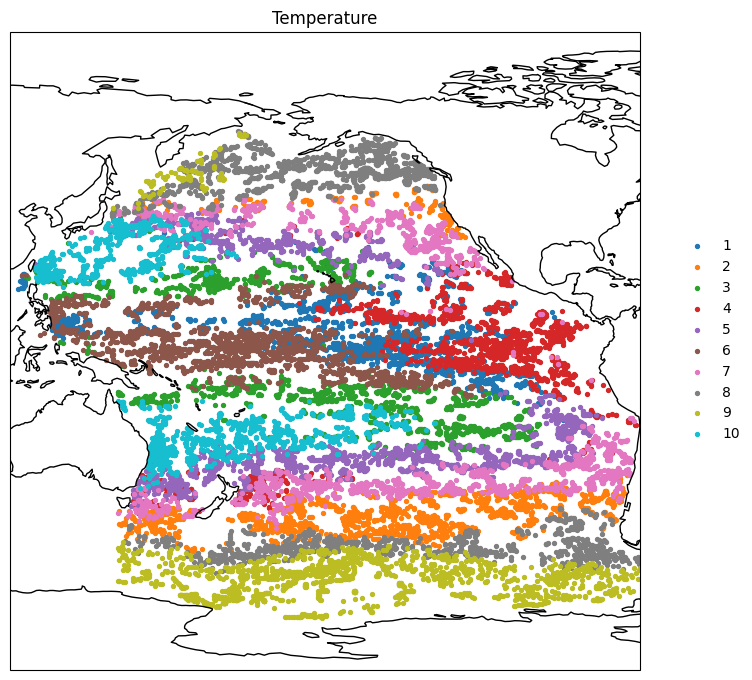

<Figure size 640x480 with 0 Axes>

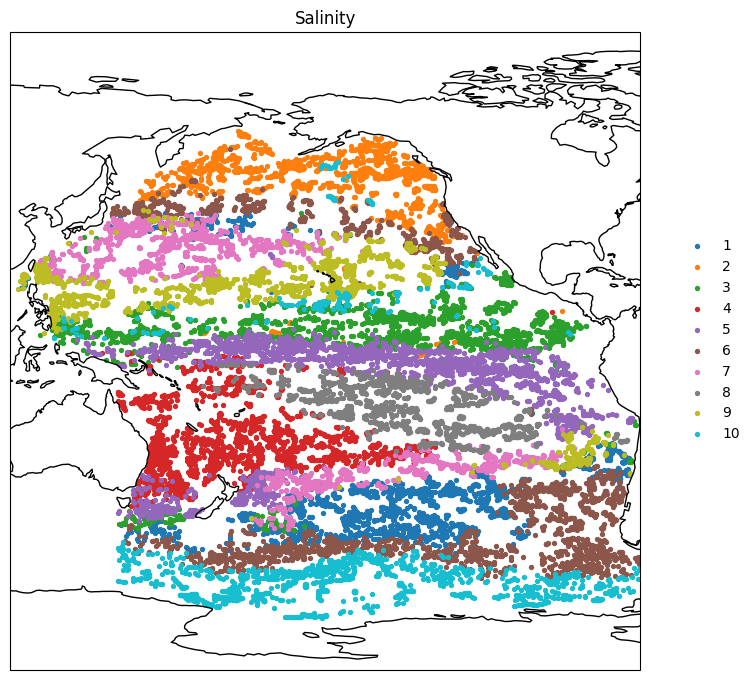

In [15]:
npt = 10
for j,x in enumerate([temp, psal]):
    S = spt[j][npt]
    ii = support_neighbor(x, S)
    plot_support_map(ii, ["Temperature", "Salinity"][j])

# Stability analysis of support point estimation

One of the principles of [veridical data science](https://vdsbook.com) is *stability*, which basically means that the results should not be highly sensitive to appropriate small data perturbations or reasonable alternatives to the data analysis methods that are employed.  Below we conduct a very simplistic stability assessment for the support point analysis.  We will perturb the data by subsampling 10,000 observations at a time without replacement.  We then quantify the extent to which the minimized energy distance found through the support point optimization changes substantially upon subsampling.  In addition, we assess the extent to which the support points themselves are stable upon conducting this subsampling. 


Recall from above that the average Euclidean distance between two temperature profiles is around 40.8 and the average Euclidean distance between two salinity profiles is 4.8.  These numbers will be helpful in interpreting the stability findings below.

Below we calculate 'npt' support points 'nrep' times, each time using a random subsample of 10,000 profiles.  Set the variable 'x' to either 'temp' or 'psal' to conduct this stability analysis on the temperature or salinity data.

In [ ]:
npt = 10
nrep = 5
x = temp
S = []
for _ in range(nrep):
    ii = np.random.choice(temp.shape[1], 10000, replace=False)
    X = support(x[:, ii].T, npt, maxiter=support_iter)
    S.append(X)

One way to assess stability is to check the energy distance between each set of support points and the target distribution.  This is the quantity being minimized when the support points are constructed.  This value will vary among the random subsamples as shown below.

In [ ]:
di = [energy_distance(x, s.T) for s in S]
di

We can compare these energy distances to the distances between a random subset of profiles (of the same size) and the full dataset.  This analysis shows that the 'm' support points do a much better job of representing the population than a random set of 'm' profiles.

In [ ]:
for _ in range(5):
    ii = np.random.choice(x.shape[1], npt, replace=False)
    x1 = x[:, ii[0:npt]]
    print(energy_distance(x1, x))

We can also consider the energy distance between two sets of support points:

In [ ]:
di = []
for i in range(len(S)):
    for j in range(i):
        di.append(energy_distance(S[i].T, S[j].T))
di 

The results above indicate that the distance between two sets of support points is generally greater than the distance from either of them to the data that they are trained to represent.  This suggests that the support points are not especially "stable".  This is not necessarily a problem since all of the support point sets that the algorithm finds perform approximately equally well at representing the population of interest.

How do we know whether the numbers above should be considered to be "big"?  One approach is to consider the energy distances between pairs of random samples of profiles, of the same size as the support point sets.  These distances turn out to be much larger and more variable than the distances between sets of support points.

In [ ]:
for _ in range(5):
    ii = np.random.choice(temp.shape[1], 2*npt, replace=False)
    x1 = x[:, ii[0:npt]]
    x2 = x[:, ii[npt:2*npt]]
    print(energy_distance(x1, x2))